In [1]:
import re
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
max_vocab_size = 70000
MAX_SENTENCE_LENGTH = 800
emb_dim = 100
n_gram_model = 2
optimizer_flag = 1 #0 for SGD, 1 for Adam

In [3]:
def load_train_test_imdb_data(data_dir):
    """Loads the IMDB train/test datasets from a folder path.
    Input:
    data_dir: path to the "aclImdb" folder.
    
    Returns:
    train/test datasets as pandas dataframes.
    """
    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            print(path)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[split].append([review, score])
    np.random.seed(0)
    np.random.shuffle(data["train"])  
    np.random.shuffle(data["test"])
    train_data = []
    train_targets = []
    test_data = []
    test_targets = []
    for i in range(len(data["train"])):
        train_data.append(data["train"][i][0])
        train_targets.append(data["train"][i][1])
    
    for i in range(len(data["test"])):
        test_data.append(data["test"][i][0])
        test_targets.append(data["test"][i][1])
    return train_data, train_targets, test_data, test_targets

all_train_data, all_train_targets, test_data, test_targets = load_train_test_imdb_data(data_dir="./aclImdb")
train_split = 20000
train_data = all_train_data[:train_split]
train_targets = all_train_targets[:train_split]

val_data = all_train_data[train_split:]
val_targets = all_train_targets[train_split:]

print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

./aclImdb/train/neg
./aclImdb/train/pos
./aclImdb/test/neg
./aclImdb/test/pos
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [4]:
# Let's write the tokenization function 
import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
#def tokenize(sent):
#  tokens = tokenizer(sent)
#  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

def tokenize(sent):
   tokens = tokenizer(sent)
   return [token.lemma_.lower() for token in tokens if (token.lemma_ not in punctuations)]

# Example
tokens = tokenize(u'Apple is looking at buying U.K. startup for $1 billion')
print (tokens)

['apple', 'be', 'look', 'at', 'buy', 'u.k.', 'startup', 'for', '1', 'billion']


In [5]:
# This is the code cell that tokenizes train/val/test datasets
# However it takes about 15-20 minutes to run it
# For convinience we have provided the preprocessed datasets
# Please see the next code cell
import pickle as pkl

def tokenize_dataset(dataset, ngram=1):
    token_dataset = []
    # we are keeping track of all tokens in dataset
    # in order to create vocabulary later
    all_tokens = []
    if ngram == 1:
        for sample in tqdm(dataset):
            tokens = tokenize(sample)
            token_dataset.append(tokens)
            all_tokens += tokens
    elif ngram == 2:
        for sample in tqdm(dataset):
            tokens = tokenize(sample)
            bigram_tokens = []
            for i in range(len(tokens)-1):
                bigram_tokens.append(tokens[i] + ' '+ tokens[i+1])
            token_dataset.append(bigram_tokens)
            all_tokens += bigram_tokens
    elif ngram == 3:
        for sample in tqdm(dataset):
            tokens = tokenize(sample)
            trigram_tokens = []
            for i in range(len(tokens)-2):
                trigram_tokens.append(tokens[i] + ' '+ tokens[i+1] + ' ' + tokens[i+2])
            token_dataset.append(trigram_tokens)
            all_tokens += trigram_tokens
    elif ngram == 4:
        for sample in tqdm(dataset):
            tokens = tokenize(sample)
            fourgram_tokens = []
            for i in range(len(tokens)-3):
                fourgram_tokens.append(tokens[i] + ' '+ tokens[i+1] + ' ' + tokens[i+2] + ' ' + tokens[i+3])
            token_dataset.append(fourgram_tokens)
            all_tokens += fourgram_tokens
    return token_dataset, all_tokens

def n_gram_transform(tokens_data, ngram=1):
    token_dataset = []
    # we are keeping track of all tokens in dataset
    # in order to create vocabulary later
    all_tokens = []
    print("{}-gram model".format(ngram))
    if ngram == 1:
        for i in tqdm(range(len(tokens_data))):
            tokens = tokens_data[i]
            token_dataset.append(tokens)
            all_tokens += tokens
    elif ngram == 2:
        for i in tqdm(range(len(tokens_data))):
            tokens = tokens_data[i]
            bigram_tokens = []
            for i in range(len(tokens)-1):
                bigram_tokens.append(tokens[i] + ' '+ tokens[i+1])
            token_dataset.append(bigram_tokens)
            all_tokens += bigram_tokens
    elif ngram == 3:
        for i in tqdm(range(len(tokens_data))):
            tokens = tokens_data[i]
            trigram_tokens = []
            for i in range(len(tokens)-2):
                trigram_tokens.append(tokens[i] + ' '+ tokens[i+1] + ' ' + tokens[i+2])
            token_dataset.append(trigram_tokens)
            all_tokens += trigram_tokens
    elif ngram == 4:
        for i in tqdm(range(len(tokens_data))):
            tokens = tokens_data[i]
            fourgram_tokens = []
            for i in range(len(tokens)-3):
                fourgram_tokens.append(tokens[i] + ' '+ tokens[i+1] + ' ' + tokens[i+2] + ' ' + tokens[i+3])
            token_dataset.append(fourgram_tokens)
            all_tokens += fourgram_tokens
    return token_dataset, all_tokens

In [ ]:
# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data, 1)
pkl.dump(val_data_tokens, open("val_data_tokens_new_lemma.p", "wb"))

In [ ]:
# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data, 1)
pkl.dump(test_data_tokens, open("test_data_tokens_new_lemma.p", "wb"))

In [ ]:
# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data, 1)
pkl.dump(train_data_tokens, open("train_data_tokens_new_lemma.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens_new_lemma.p", "wb"))

In [ ]:
len(set(all_train_tokens))

In [6]:
# First, download datasets from here
# Use your NYU account
#https://drive.google.com/open?id=1eR2LFI5MGliHlaL1S2nsX4ouIO1k_ip2
#https://drive.google.com/open?id=133QCWbiz_Xc7Qm4r6t-fJP1K669xjNlM
#https://drive.google.com/open?id=1SuUIUpJ1iznU707ktkpnEGSwt_XIqOYp
#https://drive.google.com/open?id=1UQsrZ2LVfcxdxxa47344fMs_qvya72KR


# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens_new_lemma.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_new_lemma.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_new_lemma.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_new_lemma.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4811775


In [7]:
# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = n_gram_transform(val_data_tokens, n_gram_model)
#pkl.dump(val_data_tokens, open("val_data_tokens_new_2.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = n_gram_transform(test_data_tokens, n_gram_model)
#pkl.dump(test_data_tokens, open("test_data_tokens_new_2.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = n_gram_transform(train_data_tokens, n_gram_model)
#pkl.dump(train_data_tokens, open("train_data_tokens_new_2.p", "wb"))
#pkl.dump(all_train_tokens, open("all_train_tokens_new_2.p", "wb"))

 26%|██▌       | 1291/5000 [00:00<00:00, 12909.95it/s]

Tokenizing val data
2-gram model


  6%|▌         | 1456/25000 [00:00<00:01, 14548.39it/s]

Tokenizing test data
2-gram model


  7%|▋         | 1460/20000 [00:00<00:01, 14434.55it/s]

Tokenizing train data
2-gram model


100%|██████████| 20000/20000 [00:01<00:00, 12727.44it/s]


In [8]:
print(len(set(all_train_tokens)))
print(len(all_train_tokens))

1036997
4791775


Now, we are going to create the vocabulary of most common 10,000 tokens in the training set.

In [9]:
from collections import Counter
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [10]:
# Lets check the dictionary by loading random token from it
random_token_id = np.random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 12032 ; token the cake
Token the cake; token id 12032


In [11]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


Now we are going to create PyTorch DataLoader 

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)



In [13]:
for i, (data, lengths, labels) in enumerate(train_loader):
    print (data)
    print (labels)
    break

tensor([[   39,    87,   127,  ...,     0,     0,     0],
        [48179,   498, 23209,  ...,     0,     0,     0],
        [ 2166, 15498,   470,  ...,    87,    83,  1245],
        ...,
        [ 6574, 30903, 21645,  ...,     0,     0,     0],
        [    1,     1,     1,  ...,     0,     0,     0],
        [ 2139, 68080,     1,  ...,     0,     0,     0]])
tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 1])


Here we will define Bag-of-Words model in PyTorch

In [14]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out
    
model = BagOfWords(len(id2token), emb_dim)

In [15]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if optimizer_flag == 0:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    print('choose SGD as optimizer')
elif optimizer_flag == 1:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print('choose Adam as optimizer')

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
loss_list =[]

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        
    return (100 * correct / total, total)

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_num = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, validation_num: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, val_num))

    

choose Adam as optimizer
Epoch: [1/10], Step: [101/625], Validation Acc: 79.46, validation_num: 5000
Epoch: [1/10], Step: [201/625], Validation Acc: 85.56, validation_num: 5000
Epoch: [1/10], Step: [301/625], Validation Acc: 86.16, validation_num: 5000
Epoch: [1/10], Step: [401/625], Validation Acc: 87.22, validation_num: 5000
Epoch: [1/10], Step: [501/625], Validation Acc: 87.92, validation_num: 5000
Epoch: [1/10], Step: [601/625], Validation Acc: 88.68, validation_num: 5000
Epoch: [2/10], Step: [101/625], Validation Acc: 88.9, validation_num: 5000
Epoch: [2/10], Step: [201/625], Validation Acc: 88.9, validation_num: 5000
Epoch: [2/10], Step: [301/625], Validation Acc: 89.18, validation_num: 5000
Epoch: [2/10], Step: [401/625], Validation Acc: 88.42, validation_num: 5000
Epoch: [2/10], Step: [501/625], Validation Acc: 88.46, validation_num: 5000
Epoch: [2/10], Step: [601/625], Validation Acc: 88.46, validation_num: 5000
Epoch: [3/10], Step: [101/625], Validation Acc: 88.38, validation

TypeError: imshow() missing 1 required positional argument: 'X'

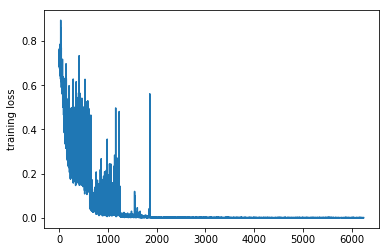

In [17]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.ylabel('training loss')
plt.imshow()

In [18]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)[0]))
print ("Test Acc {}".format(test_model(test_loader, model)[0]))
print ("Train Acc {}".format(test_model(train_loader, model)[0]))

After training for 10 epochs
Val Acc 88.68
Test Acc 87.556
Train Acc 100.0


In [19]:
good_num = 3
good_sample = []
good_label = []
bad_num = 3
bad_sample = []
bad_label = []
pre_label = []
for data, lengths, labels in val_loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        for i in range(len(predicted)):
            if predicted[i,0] == label_batch[i]:
                good_sample.append(data_batch[i])
                good_label.append(label_batch[i])
                good_num+=1
            else:
                bad_sample.append(data_batch[i])
                bad_label.append(label_batch[i])
                pre_label.append(predicted[i,0])
                bad_num+=1
        if good_num > 10 and bad_num > 10:
            break


In [ ]:
for i in range(len(good_sample)):
    sample = []
    for j in range(len(good_sample[i])):
        sample.append(id2token[good_sample[i][j]])
    print(good_label[i])
    print(sample)
    

In [ ]:
for i in range(len(bad_sample)):
    sample = []
    for j in range(len(bad_sample[i])):
        current_id = int(bad_sample[i][j])
        sample.append(id2token[current_id])
    print(bad_label[i])
    print(pre_label[i])
    print(sample)